In [104]:
# import general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import different models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

# import evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# import model tuning methods
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import hyperopt

# visualisations
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO 
from IPython.display import Image

## 0. Data preparation

In [105]:
df = pd.read_csv('cardio_train_cleaned.csv')

df.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,72,1,110,80,1,1,0,0,1,0,21.967
1,67,0,140,90,3,1,0,0,1,1,34.928
2,71,0,130,70,3,1,0,0,0,1,23.508
3,74,1,150,100,1,1,0,0,1,1,28.710
4,75,0,100,60,1,1,0,0,0,0,23.011


In [106]:
# split dataframe into variables and label
X = df.drop('cardio', axis=1)
y = df['cardio']

# split data into train and validation and test
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, stratify=y_rem, random_state=42)

## 1. Decision Tree

In [107]:
# hyperparameter tuning with Hyperopt
def objective(search_space):
    clf = DecisionTreeClassifier(**search_space)
    current_score = cross_val_score(clf, X_valid, y_valid, cv=10).mean()
    print(current_score, search_space)
    return {'loss': -current_score, 'status': STATUS_OK}

search_space = {
            'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
            'max_depth': hp.choice('max_depth', range(1,100)),
            'max_leaf_nodes': hp.choice('max_leaf_nodes', range(1,100))
        }

best_params_base = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=10)
print('Best:')
print(best_params_base)
    

0.7136175403890537                                                                                                     
{'criterion': 'log_loss', 'max_depth': 43, 'max_leaf_nodes': 3}                                                        
0.7192476096274316                                                                                                     
{'criterion': 'entropy', 'max_depth': 42, 'max_leaf_nodes': 71}                                                        
0.7198428398725134                                                                                                     
{'criterion': 'log_loss', 'max_depth': 64, 'max_leaf_nodes': 49}                                                       
0.7193959775799539                                                                                                     
{'criterion': 'entropy', 'max_depth': 46, 'max_leaf_nodes': 68}                                                        
0.7204341136388615                      

In [108]:
# Get algorithm string as hp.choice only can display the integer
criterion_dic = {0:'gini', 1:'entropy', 2:'log_loss'}
criterion = criterion_dic[best_params_base['criterion']]

# # fit hyperparamater(Hyperopt) and train data into the model
clf = DecisionTreeClassifier(criterion=criterion, max_depth = best_params_base['max_depth'], max_leaf_nodes=best_params_base['max_leaf_nodes'])
model = clf.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# evaluation metrics
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train, average='binary')
recall = recall_score(y_train, y_pred_train, average='binary')
f1 = f1_score(y_train, y_pred_train, average='binary')

print('Train Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='binary')
recall = recall_score(y_test, y_pred_test, average='binary')
f1 = f1_score(y_test, y_pred_test, average='binary')

print('\nTest Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

Train Results
Accuracy:  0.7282868525896414
Precision:  0.7278182099721275
Recall:  0.7112700034048348
f1_score: 0.7194489620204726

Test Results
Accuracy:  0.7245775274236584
Precision:  0.7209657701711492
Recall:  0.7139830508474576
f1_score: 0.7174574209245742


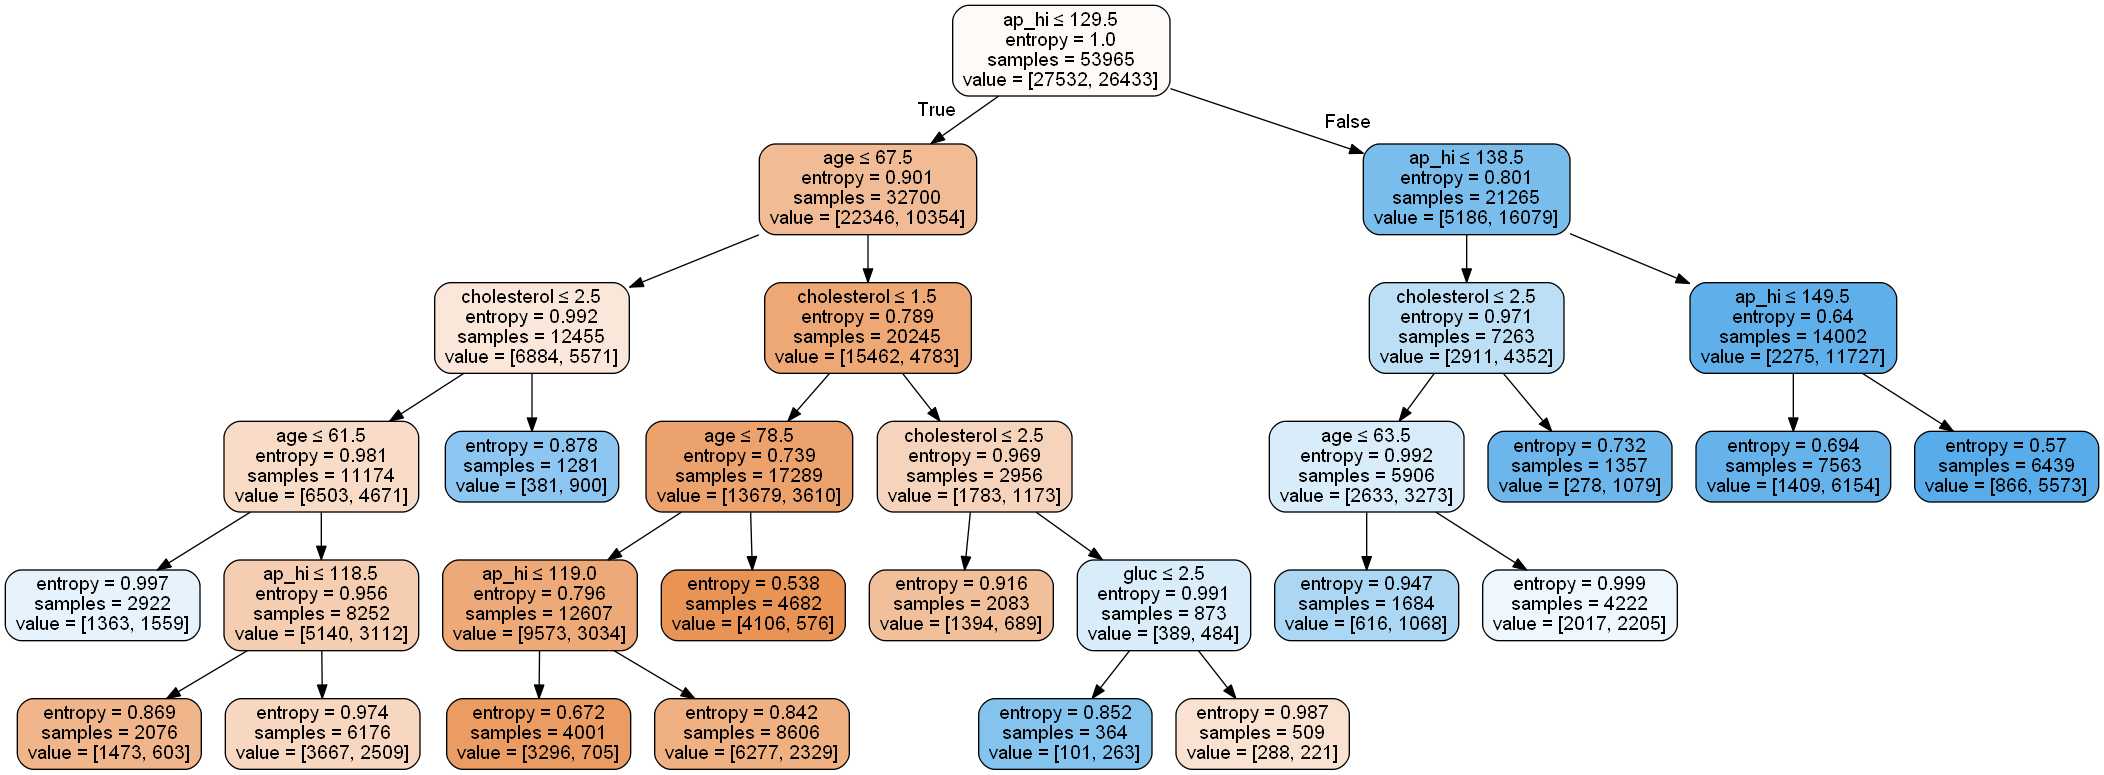

In [109]:
# visualisation for Decision Tree
feature_cols = X.columns

dot_data = StringIO()
export_graphviz(clf, out_file = dot_data, 
                      feature_names = feature_cols,  
                     filled = True, rounded = True,  
                    special_characters = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## 2. Bagging with Decision Tree

In [110]:
# hyperparameter tuning with Hyperopt
def objective(search_space):
    dtc = DecisionTreeClassifier(criterion=criterion, max_depth = best_params_base['max_depth'], max_leaf_nodes=best_params_base['max_leaf_nodes'])
    clf = BaggingClassifier(**search_space, base_estimator=dtc)
    current_score = cross_val_score(clf, X_valid, y_valid, cv=10).mean()
    print(current_score, search_space)
    return {'loss': -current_score, 'status': STATUS_OK}

search_space = {
            'n_estimators': hp.choice('n_estimators', range(1, 1000))
        }

best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=10)
print('Best:')
print(best_params)

0.726656995274206                                                                                                      
{'n_estimators': 399}                                                                                                  
0.7254700516540279                                                                                                     
{'n_estimators': 275}                                                                                                  
0.7256195186284207                                                                                                     
{'n_estimators': 700}                                                                                                  
0.7265079679085613                                                                                                     
{'n_estimators': 541}                                                                                                  
0.726063523464117                       

In [111]:
# fit hyperparamater(Hyperopt) and train data into the model
dtc = DecisionTreeClassifier(criterion=criterion, max_depth = best_params_base['max_depth'], max_leaf_nodes=best_params_base['max_leaf_nodes'])
clf = BaggingClassifier(base_estimator=dtc, n_estimators=best_params['n_estimators'], random_state=42)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# evaluation metrics
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train, average='binary')
recall = recall_score(y_train, y_pred_train, average='binary')
f1 = f1_score(y_train, y_pred_train, average='binary')

print('Train Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='binary')
recall = recall_score(y_test, y_pred_test, average='binary')
f1 = f1_score(y_test, y_pred_test, average='binary')

print('\nTest Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

Train Results
Accuracy:  0.7282868525896414
Precision:  0.7278182099721275
Recall:  0.7112700034048348
f1_score: 0.7194489620204726

Test Results
Accuracy:  0.7245775274236584
Precision:  0.7209657701711492
Recall:  0.7139830508474576
f1_score: 0.7174574209245742


Result slighly worse off compared to base estimator alone

## 3. AdaBoost with Decision Tree

In [112]:
# hyperparameter tuning with Hyperopt
def objective(search_space):
    dtc = DecisionTreeClassifier(criterion=criterion, max_depth = best_params_base['max_depth'], max_leaf_nodes=best_params_base['max_leaf_nodes'])
    clf = AdaBoostClassifier(**search_space, base_estimator=dtc)
    current_score = cross_val_score(clf, X_valid, y_valid, cv=10).mean()
    print(current_score, search_space)
    return {'loss': -current_score, 'status': STATUS_OK}

search_space = {
            'n_estimators': hp.choice('n_estimators', range(50, 1000)),
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'algorithm': hp.choice('algorithm', ['SAMME', 'SAMME.R'])
        }

best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=10)
print('Best:')
print(best_params)
    

0.7271042971755138                                                                                                     
{'algorithm': 'SAMME.R', 'learning_rate': 0.0028, 'n_estimators': 236}                                                 
0.7291790306627102                                                                                                     
{'algorithm': 'SAMME', 'learning_rate': 0.0313, 'n_estimators': 280}                                                   
0.7118344873062975                                                                                                     
{'algorithm': 'SAMME.R', 'learning_rate': 0.0094, 'n_estimators': 886}                                                 
0.7285859984613694                                                                                                     
{'algorithm': 'SAMME', 'learning_rate': 0.0366, 'n_estimators': 297}                                                   
0.7263635564347729                      

In [113]:
# Get algorithm string as hp.choice only can display the integer
algo_dic = {0:'SAMME', 1:'SAMME.R'}
algo = algo_dic[best_params['algorithm']]

# fit hyperparamater(Hyperopt) and train data into the model
clf = AdaBoostClassifier(base_estimator=clf, n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], algorithm=algo)
model = clf.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


# evaluation metrics
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train, average='binary')
recall = recall_score(y_train, y_pred_train, average='binary')
f1 = f1_score(y_train, y_pred_train, average='binary')

print('Train Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='binary')
recall = recall_score(y_test, y_pred_test, average='binary')
f1 = f1_score(y_test, y_pred_test, average='binary')

print('\nTest Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)


Train Results
Accuracy:  0.7378856666357825
Precision:  0.7550012451232672
Recall:  0.6881927893163848
f1_score: 0.7200506659805649

Test Results
Accuracy:  0.7325822709753929
Precision:  0.7495009980039921
Recall:  0.6819007263922519
f1_score: 0.7141045958795563


Generally...

1. Bagging perform slightly worse than base estimator
2. Adaboost perform wosre in aorund 4% in recall and 1% in f1 score